# Github Natural Language Processing

#### by Ryan McCall, David Wederstrandt Sr., and Noah Melngailis

## Introduction

The purpose of this project was to see if we could use the README text of GitHub repos to predict the programming language that is used to program the majority of the repository.

We did this by using the most starred repos for JavaScript, Python, Java, and PHP as they are the top four languages on GitHub. We scraped the names of the top 200 repos for each of these languages for a total of 800 name. We then used the GitHub API to bring in the repos main language and readme contents.

We then took these files and reduced them down to keywords using text normalization with string methods, unicode conversion, regex substitution, word stemming, and word lemmatization.

Next we explored the documents by looking at similarities and differences between them. We looked at the common words shared between the documents and the common words shared by programming languages. We looked at the importance of words in each of the documents and the importance of the words based on the language of the repository. We also looked at the difference in the amount of words used by each of the these languages.

We then went on to create a model that used a Decision Tree Classifier to predict the programming language of the repository. We found that the single words used in each README yielded the most accurate model which was able to predict the language of the test set with 75% accuracy.

## Project

### Imports

In [1]:
import pandas as pd
import numpy as np

import explore
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn import tree

from wordcloud import WordCloud

import graphviz
from graphviz import Graph

from prepare import wrangle_data
import explore
import handle_outliers
import preprocessing

### Acquire

For the acquisition of the data, our acquire.py file starts by scrapping the names of the 200 most starred repos for that had JavaScript, Python, Java, or PHP as their main language. This gave us a list of 800 names that we stored in a .csv file. That was read in by our acquire file and used to make request for the name, main programming language, and README contents of the repositories. This information is then stored in a .json file that can be read into a pandas DataFrame.

This is all achieved by running `python acquire.py` in the terminal which creates the repo.csv (repo names) and data.json (repo info) files.

In [2]:
data = pd.read_json('data.json')
data

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
2,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
3,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() {\n\n*A most...
4,d3/d3,JavaScript,"# D3: Data-Driven Documents\n\n<a href=""https:..."
...,...,...,...
795,isohuntto/openbay,PHP,Openbay is not supported\n=======\n\nWarm gree...
796,geocoder-php/Geocoder,PHP,Geocoder\n========\n\n[![Build Status](https:/...
797,maximebf/php-debugbar,PHP,# PHP Debug Bar\n\n[![Latest Stable Version](h...
798,nunomaduro/phpinsights,PHP,"<p align=""center"">\n <img src=""https://raw.gi..."


### Prepare

Now this is what our some of our readme contents look like:

In [3]:
data.readme_contents[1]

'<p align="center"><a href="https://vuejs.org" target="_blank" rel="noopener noreferrer"><img width="100" src="https://vuejs.org/images/logo.png" alt="Vue logo"></a></p>\n\n<p align="center">\n  <a href="https://circleci.com/gh/vuejs/vue/tree/dev"><img src="https://img.shields.io/circleci/project/github/vuejs/vue/dev.svg?sanitize=true" alt="Build Status"></a>\n  <a href="https://codecov.io/github/vuejs/vue?branch=dev"><img src="https://img.shields.io/codecov/c/github/vuejs/vue/dev.svg?sanitize=true" alt="Coverage Status"></a>\n  <a href="https://npmcharts.com/compare/vue?minimal=true"><img src="https://img.shields.io/npm/dm/vue.svg?sanitize=true" alt="Downloads"></a>\n  <a href="https://www.npmjs.com/package/vue"><img src="https://img.shields.io/npm/v/vue.svg?sanitize=true" alt="Version"></a>\n  <a href="https://www.npmjs.com/package/vue"><img src="https://img.shields.io/npm/l/vue.svg?sanitize=true" alt="License"></a>\n  <a href="https://chat.vuejs.org/"><img src="https://img.shields.i

---

#### As you may see, there is HTML and Markdown text scattered throught the text that we want to capture. After several cleaning steps the above text was able to be turned into this:

In [4]:
df = wrangle_data()
df.lemmatized[1]

"supporting vuejsvuejs mitlicensed open source project ongoing development made possible entirely support awesome backer ' like join please consider become backer sponsor patreon become backer sponsor open collective onetime donation via paypal cryptocurrencies ' difference patreon opencollectivefunds donated via patreon go directly support evan ' fulltime work vuejs fund donated via opencollective managed transparent expense used compensating work expense core team member sponsoring community event namelogo receive proper recognition exposure donating either platformspecial sponsorsplatinum sponsorsplatinum sponsor chinagold sponsorssponsors via open collectiveplatinumgold introductionvue pronounced vju like view progressive framework building user interface designed ground incrementally adoptable easily scale library framework depending different use case consists approachable core library focus view layer ecosystem supporting library help tackle complexity large singlepage applicati

The steps to achieve this are as follows:

* First, all html tags (anything between a '<' and '>') were removed.
* Next, all urls were removed.
* Newline characters and extra spaces were also removed.
* Then anything that wasn't alphanumeric was removed.
* Next, stopwords (a, an, the, etc.) were removed.
* Finally the text was stemmed and lemmatized, each of which was placed in it's own column

In [5]:
df

,repo,language,readme_contents,stemmed,lemmatized
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerpul request welco...,freecodecamporg social bannerpull request welc...
1,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...",support vuejsvuej mitlicens open sourc project...,supporting vuejsvuejs mitlicensed open source ...
2,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",bootstrapsleek intuit power frontend framework...,bootstrapsleek intuitive powerful frontend fra...
3,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() {\n\n*A most...,airbnb javascript style guid mostli reason app...,airbnb javascript style guide mostly reasonabl...
4,d3/d3,JavaScript,"# D3: Data-Driven Documents\n\n<a href=""https:...",d3 datadriven documentsd3 d3j javascript libra...,d3 datadriven documentsd3 d3js javascript libr...
...,...,...,...,...,...
795,isohuntto/openbay,PHP,Openbay is not supported\n=======\n\nWarm gree...,openbay supportedwarm greet guestsisohunt team...,openbay supportedwarm greeting guestsisohunt t...
796,geocoder-php/Geocoder,PHP,Geocoder\n========\n\n[![Build Status](https:/...,geocoderbuild statussoftwar licenselicens impo...,geocoderbuild statussoftware licenselicense im...
797,maximebf/php-debugbar,PHP,# PHP Debug Bar\n\n[![Latest Stable Version](h...,php debug barlatest stabl version total downlo...,php debug barlatest stable version total downl...
798,nunomaduro/phpinsights,PHP,"<p align=""center"">\n <img src=""https://raw.gi...",full document visit phpinsightscomphp insight ...,full documentation visit phpinsightscomphp ins...


### Exploration

#### Feature Selection
For feature selection we created some numerical data columns:

| Feature | Description |
|--- |--- |
| word_count_simple | Count of the number of spaces in the lemmatized words |
| word_count | Count of all of the lemmatized words |
| unique_count | Count of all words, only counted once |
| non_single_count | Count of all words appearing more then once, anywhere |
| percent_unique | Percentage of unique words |
| percent_repeat | Percentage of words that repeated |
| percent_one_word | Percentage of words that appeared only once in `all_words` value_count series |
| percent_non_single | Percentage of words that appeared more than once on README.md page |

We used the `df.lemmatized` column in the creation of all the numerical columns


In [6]:
# df = preprocessing.feature_engineering(df)

In [7]:
df.describe()

,word_count_simple,word_count,unique_count,non_single_count,percent_unique,percent_repeat,percent_one_word,percent_non_single
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,624.570000,592.927500,303.475000,529.921250,0.690406,0.309594,0.795151,0.876736
std,1224.764452,1163.908955,398.172275,1057.009619,0.153371,0.153371,0.089177,0.125914
min,1.000000,1.000000,1.000000,0.000000,0.211007,0.000000,0.444444,0.000000
25%,115.000000,114.000000,87.750000,95.000000,0.596457,0.193298,0.736589,0.816556
50%,270.500000,264.500000,188.500000,235.000000,0.692774,0.307226,0.789458,0.884862
75%,596.500000,573.250000,350.500000,517.250000,0.806702,0.403543,0.860429,1.000000
max,15473.000000,15440.000000,3732.000000,14168.000000,1.000000,0.788993,1.000000,1.000000


In [8]:
plt.rcParams.update({'font.size': 14})

The `feature_selection` function is computationally heavy on creating `non_single_count` column.  It compares all words in `word_count` to `all_words.value_counts()` and returns the word only if the word appears more than once in df.

#### Below is code to save df to .csv to save time if you want to restart kernel and run multiple times.

In [9]:
df.to_csv('working.csv')

In [10]:
df = pd.read_csv('working.csv')
df = df.drop(columns='Unnamed: 0')

#### Outliers

Initally we handled outliers to make visualizations of numerical data better.  The high outliers.  As you can see below, it improves the interperetability of the visualizations.

There are two unseen factors that occurred when dealing with the outliers:
    1.  The descriptive statistics of each column changed immensely
    2.  **Argument for the bottom of this sub section** Should we use data with outliers or not for modelling
    
The visualization with NO outliers is better for interpretation, but the values have changed so radically that we decided to model and do most of our non-numeric visualizations using full data set.  For that reason we have removed the `xticks` from the below viz as well.  The takeaway is that javascript and python have longer README.md than php and java.  This is somewhat expected as python and javascript our programming languages with a more robust tradition of documentation

In [11]:
df_no_outliers = handle_outliers.remove_outliers(df, 3)
df_no_outliers

,repo,language,readme_contents,stemmed,lemmatized,word_list,unique_words,non_single_words,word_count_simple,word_count,unique_count,non_single_count,percent_unique,percent_repeat,percent_one_word,percent_non_single
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerpul request welco...,freecodecamporg social bannerpull request welc...,"['freecodecamporg', 'social', 'bannerpull', 'r...",['freecodecamporg' 'social' 'bannerpull' 'requ...,"['freecodecamporg', 'social', 'request', 'sour...",614,601,394,541,0.655574,0.344426,0.751269,0.900166
1,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...",support vuejsvuej mitlicens open sourc project...,supporting vuejsvuejs mitlicensed open source ...,"['supporting', 'vuejsvuejs', 'mitlicensed', 'o...",['supporting' 'vuejsvuejs' 'mitlicensed' 'open...,"['supporting', 'mitlicensed', 'open', 'source'...",272,269,212,230,0.788104,0.211896,0.801887,0.855019
2,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",bootstrapsleek intuit power frontend framework...,bootstrapsleek intuitive powerful frontend fra...,"['bootstrapsleek', 'intuitive', 'powerful', 'f...",['bootstrapsleek' 'intuitive' 'powerful' 'fron...,"['intuitive', 'powerful', 'frontend', 'framewo...",487,479,328,394,0.684760,0.315240,0.795732,0.822547
4,d3/d3,JavaScript,"# D3: Data-Driven Documents\n\n<a href=""https:...",d3 datadriven documentsd3 d3j javascript libra...,d3 datadriven documentsd3 d3js javascript libr...,"['d3', 'datadriven', 'documentsd3', 'd3js', 'j...",['d3' 'datadriven' 'documentsd3' 'd3js' 'javas...,"['d3', 'datadriven', 'd3js', 'javascript', 'li...",129,129,100,112,0.775194,0.224806,0.850000,0.868217
5,facebook/react-native,JavaScript,"<h1 align=""center"">\n <a href=""https://reactn...",react nativelearn write anywherebuild mobil ap...,react nativelearn write anywherebuild mobile a...,"['react', 'nativelearn', 'write', 'anywherebui...",['react' 'nativelearn' 'write' 'anywherebuild'...,"['react', 'write', 'mobile', 'apps', 'started'...",347,346,225,304,0.650289,0.349711,0.777778,0.878613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,isohuntto/openbay,PHP,Openbay is not supported\n=======\n\nWarm gree...,openbay supportedwarm greet guestsisohunt team...,openbay supportedwarm greeting guestsisohunt t...,"['openbay', 'supportedwarm', 'greeting', 'gues...",['openbay' 'supportedwarm' 'greeting' 'guestsi...,"['openbay', 'greeting', 'team', 'closing', 'op...",554,546,349,445,0.639194,0.360806,0.742120,0.815018
796,geocoder-php/Geocoder,PHP,Geocoder\n========\n\n[![Build Status](https:/...,geocoderbuild statussoftwar licenselicens impo...,geocoderbuild statussoftware licenselicense im...,"['geocoderbuild', 'statussoftware', 'licenseli...",['geocoderbuild' 'statussoftware' 'licenselice...,"['statussoftware', 'licenselicense', 'importan...",1256,1211,624,959,0.515277,0.484723,0.762821,0.791908
797,maximebf/php-debugbar,PHP,# PHP Debug Bar\n\n[![Latest Stable Version](h...,php debug barlatest stabl version total downlo...,php debug barlatest stable version total downl...,"['php', 'debug', 'barlatest', 'stable', 'versi...",['php' 'debug' 'barlatest' 'stable' 'version' ...,"['php', 'debug', 'stable', 'version', 'total',...",160,160,124,131,0.775000,0.225000,0.838710,0.818750
798,nunomaduro/phpinsights,PHP,"<p align=""center"">\n <img src=""https://raw.gi...",full document visit phpinsightscomphp insight ...,full documentation visit phpinsightscomphp ins...,"['full', 'documentation', 'visit', 'phpinsight...",['full' 'documentation' 'visit' 'phpinsightsco...,"['full', 'documentation', 'visit', 'insight', ...",96,96,83,84,0.864583,0.135417,0.891566,0.875000


In [12]:
print(f'The initial df has {df.shape[0]} rows') 
print(f'The df_no_outliers has {df_no_outliers.shape[0]} rows')
p = round(1 - (df_no_outliers.shape[0]/df.shape[0]), 3)*100
print(f'{p}% of the rows have been dropped for outliers')

The initial df has 800 rows
The df_no_outliers has 739 rows
7.6% of the rows have been dropped for outliers


Text(0.5, 0.98, 'Outliers Screwing Up Your Awesome Visualization')

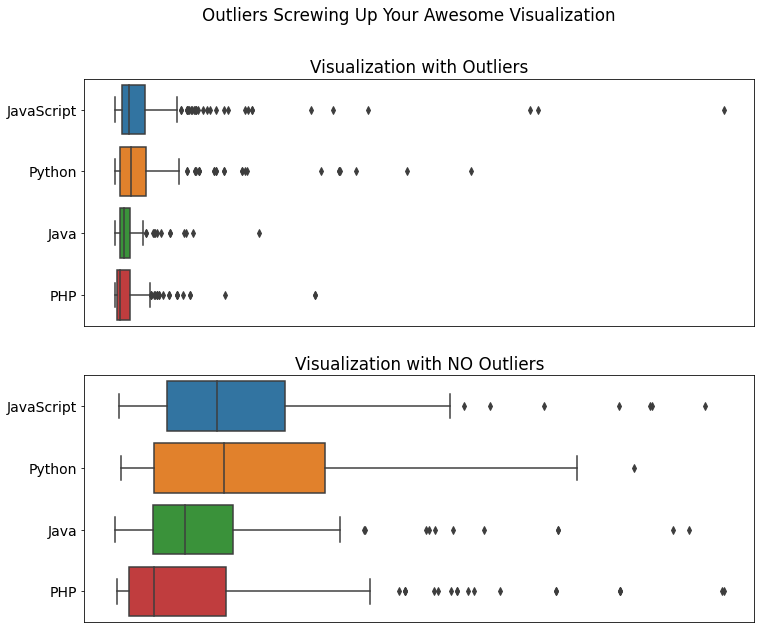

In [13]:
f = plt.figure(figsize=(12,10))
f.add_subplot(2, 1, 1)

sns.boxplot(x ='word_count', y='language', data=df)
plt.title('Visualization with Outliers')
plt.xlabel("")
plt.ylabel("")
plt.xticks([])

f.add_subplot(2, 1, 2)
sns.boxplot(x ='word_count', y='language', data=df_no_outliers)
plt.title('Visualization with NO Outliers')
plt.xlabel("")
plt.ylabel("")
plt.xticks([])

plt.suptitle("Outliers Screwing Up Your Awesome Visualization")

##### The Cost of Outliers

While removing outliers can make for visualizations that are easier to interpret, in this instance removing the outliers had such a massive change in the descriptive statistics we decided to leave them in for modelling and making word frequency visualizations.  We set k=3 in our IQR outlier test.

Given more time we would want to model and visualize on the outlier free data set as well to see if it improves our result. 

Python and JavaScript word counts mean change by about 50% if outliers are removed.  That is too much of a difference.

*Notes: for the sake of time we dropped rows instead of moving values.  We would expect better results moving values

In [14]:
df_dif = df.groupby('language').word_count.agg(['mean'])
df_dif['mean_change'] = (df.groupby('language').word_count.agg('mean') -
          df_no_outliers.groupby('language').word_count.agg('mean'))
df_dif['percent_change'] =  df_dif.mean_change / df_dif['mean']
df_dif = df_dif.reset_index()
df_dif

,language,mean,mean_change,percent_change
0,Java,321.475,25.242677,0.078521
1,JavaScript,867.970,463.185116,0.533642
2,PHP,358.650,67.471429,0.188126
3,Python,823.615,400.273960,0.485996


Text(0, 0.5, '')

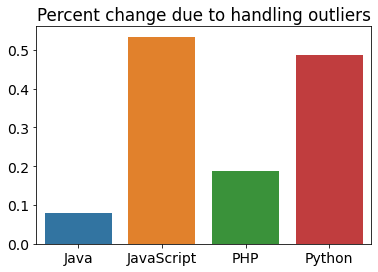

In [15]:
sns.barplot(x='language', y='percent_change', data=df_dif)
plt.title("Percent change due to handling outliers")
plt.xlabel("")
plt.ylabel("")

#### New Data Frames

To answer the exploratory visualizations we made some new dataframes.  

| Data Frames | Description |
|--- |--- |
| freq_df | dataframe of value counts for each word |
| language_df | dataframe of what language each word shows up in and how often |
| sparse_matrix | dataframe for modelling that is mostly 0 |

In [16]:
freq_df = preprocessing.language_series(df)

In [17]:
var = freq_df.shape
print(f'freq_df is {var[0]} rows and {var[1]} columns')
print(f'rows are unique words in df and columns are programming languages')
freq_df.head(3)

freq_df is 81789 rows and 5 columns
rows are unique words in df and columns are programming languages


,all,php,python,java,java_script
0,515,36,256,41,182
00,53,5,40,1,7
000,15,5,6,2,2


In [18]:
language_df = preprocessing.make_language_df(df)

In [19]:
var = language_df.shape
print(f'language_df is {var[0]} rows and {var[1]} columns')
print(f'rows are most common occurring words and columns are programming languages')
print('This data frame shows in which README.md do common words show up')
print('For the sake of time we have limited rows to 15 but that can be increased')
language_df.head(3)

language_df is 15 rows and 6 columns
rows are most common occurring words and columns are programming languages
This data frame shows in which README.md do common words show up
For the sake of time we have limited rows to 15 but that can be increased


,word,all_languages,javascript,python,php,java
0,use,618,170,159,138,151
1,code,543,156,154,127,106
2,file,455,122,116,97,120


In [20]:
import explore
sparse_matrix = explore.make_sparse_matrix(df.lemmatized, n=15)

#### Visualizations

This visualization shows the distplot, which is histogram with a trendline, of all numeric
values in dataframe.  The x-axis is target amount.  The distribution of the data is normal
for the percent columns and poisson for the counted variables.  Interestingly, the most
derived variable also has a non-traditional distribution


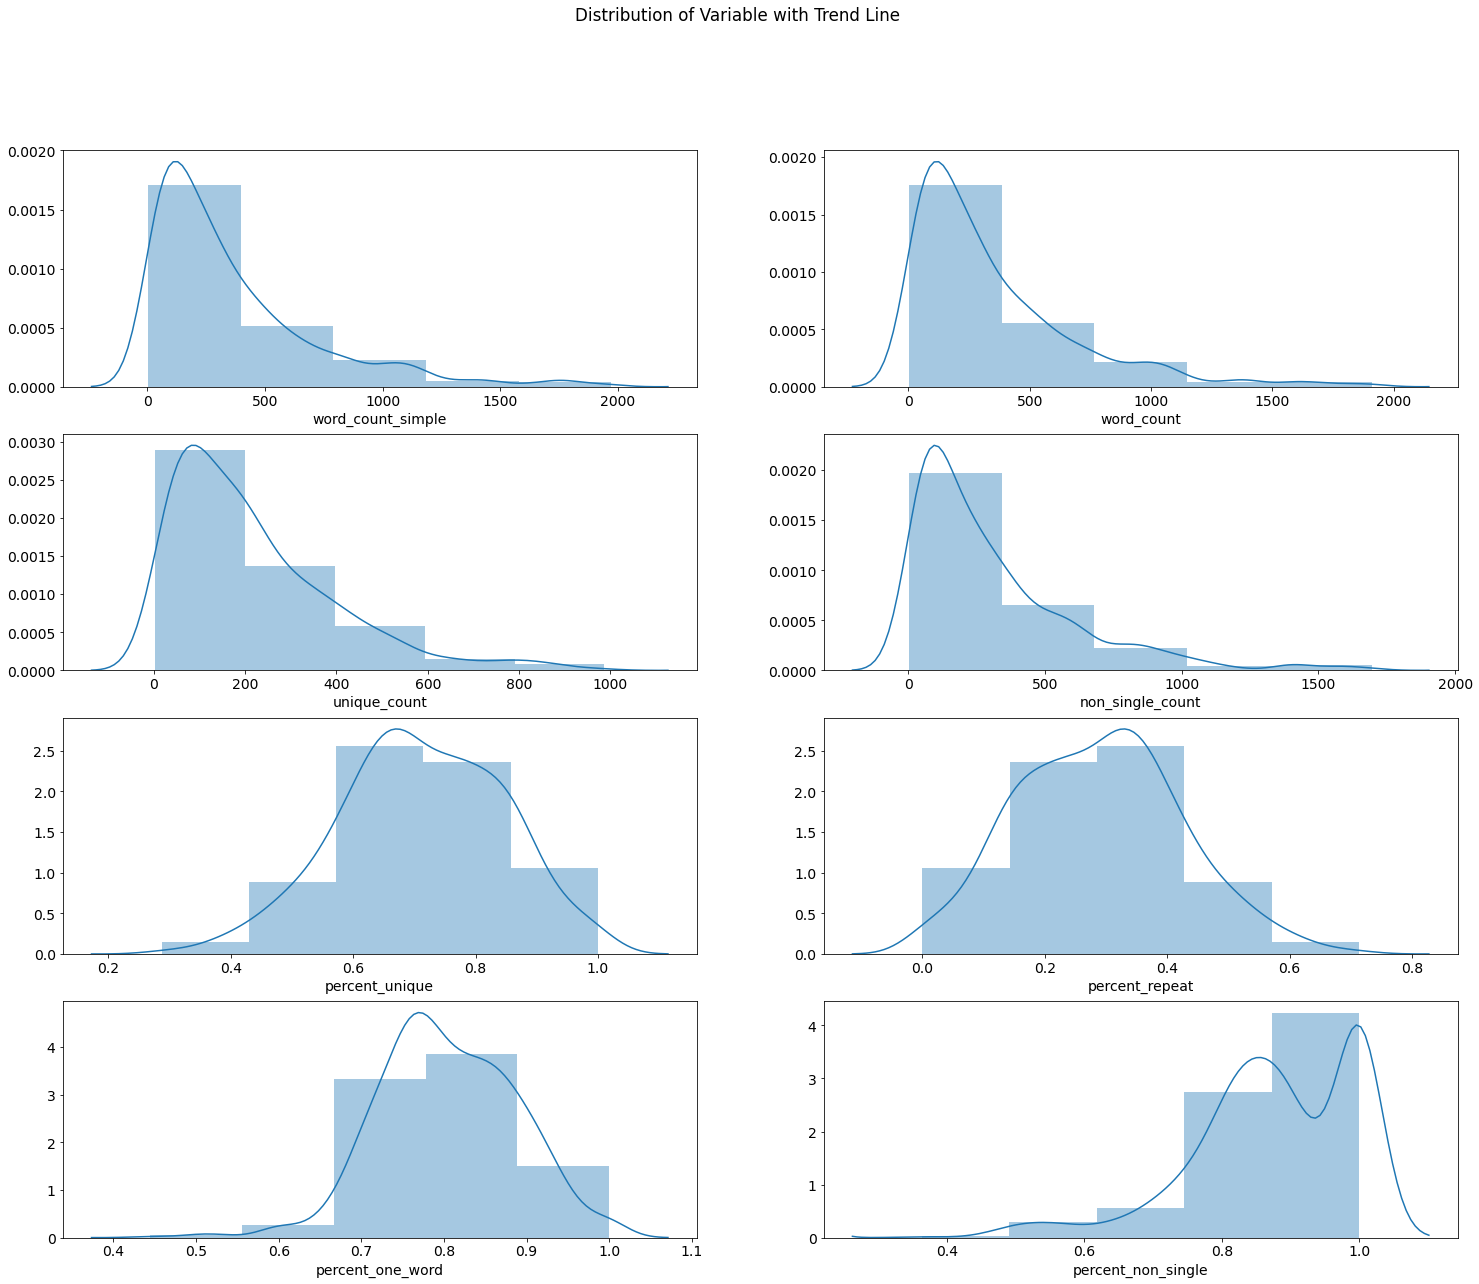

In [21]:
f = plt.figure(figsize=(25,20))
continuous_data = df_no_outliers.select_dtypes(include=["int", "float"])
plt.suptitle("Distribution of Variable with Trend Line")

print('This visualization shows the distplot, which is histogram with a trendline, of all numeric') 
print('values in dataframe.  The x-axis is target amount.  The distribution of the data is normal')
print('for the percent columns and poisson for the counted variables.  Interestingly, the most')
print('derived variable also has a non-traditional distribution')

for i in range(0,8):
    f.add_subplot(4,2, i+1)
    sns.distplot(continuous_data.iloc[:,i], bins=5)
plt.show()


In exploring the data, we created four percentage variable comparing the count of: 

- unique words 
- repeating words
- words that only show up one time in the entire df
- words that are used multiple times in a specific README.md

we wanted to explore if the count of those variables or the percentages at which they occur in a specific README.md can reveal some information about the which language the README.md was written in.  Unfortunately, they do not

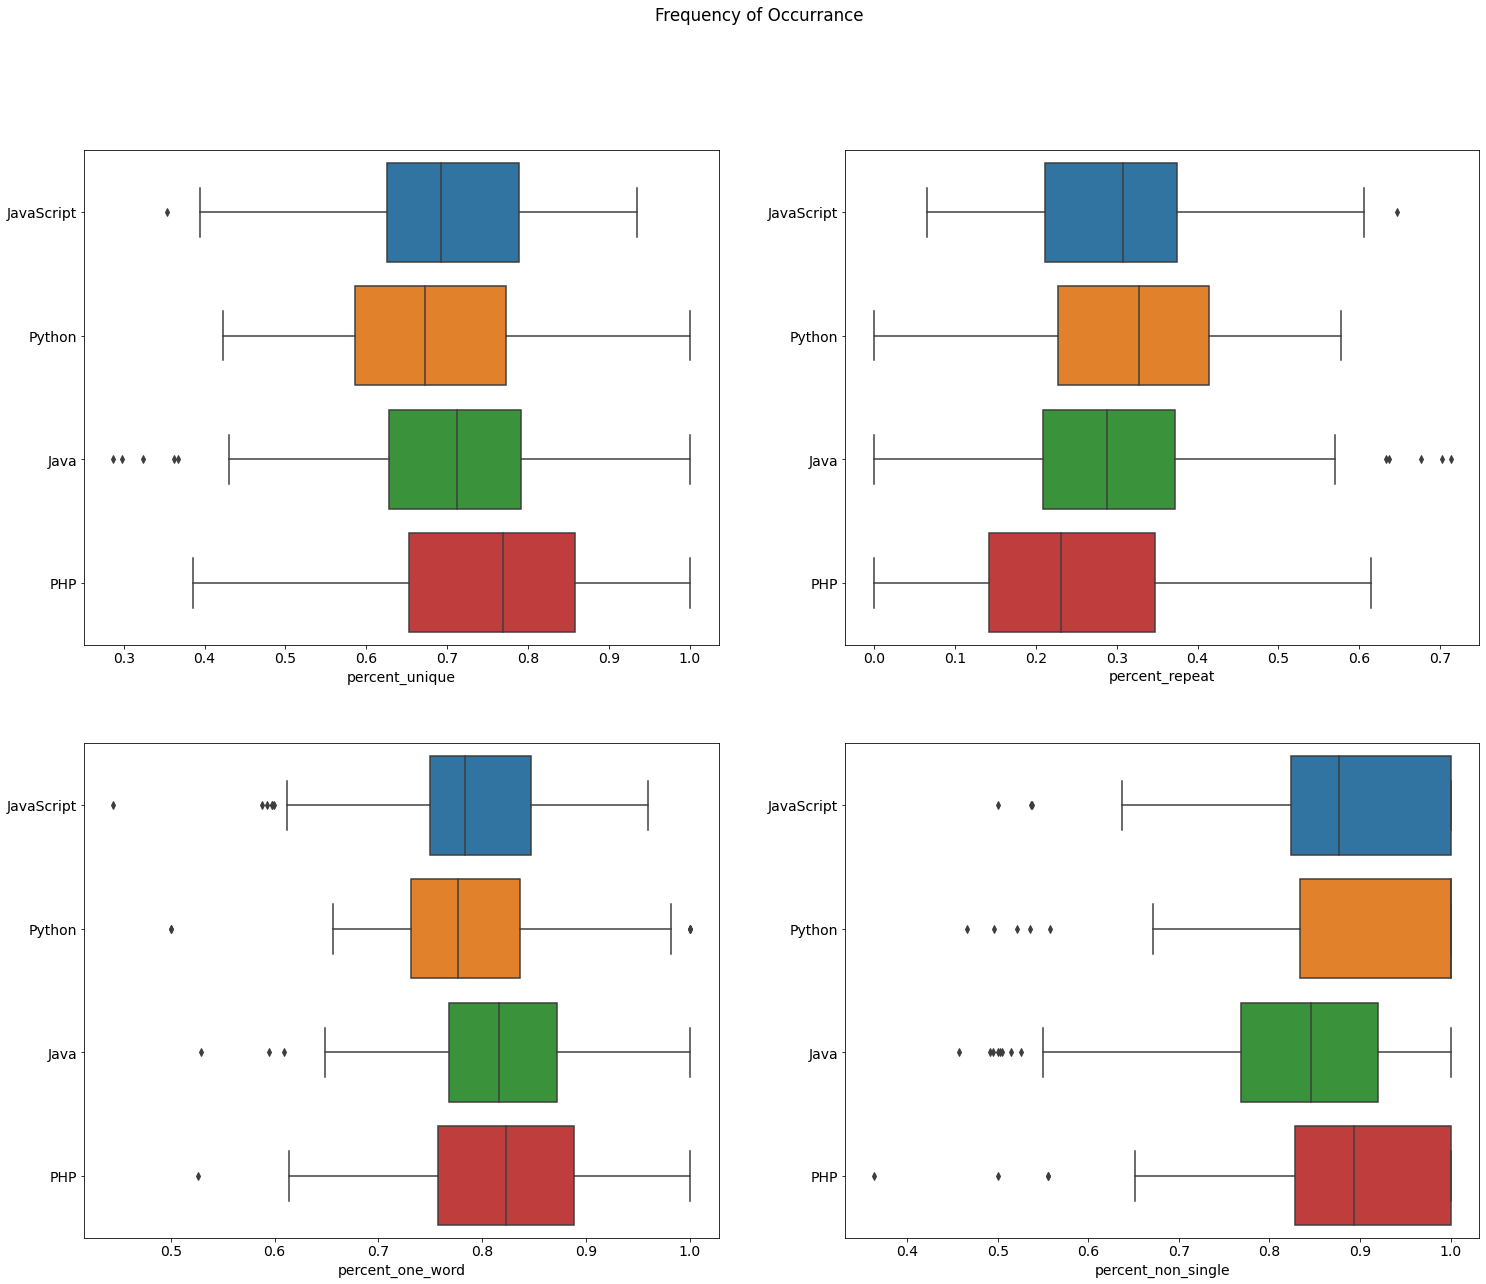

In [22]:
f = plt.figure(figsize=(25,20))
continuous_data = df_no_outliers.select_dtypes(include=["float"])

plt.suptitle("Frequency of Occurrance")

for i in range(0,4):
    f.add_subplot(2,2, i+1)
    sns.boxplot(x = continuous_data.iloc[:,i], y=df_no_outliers.language)
    plt.ylabel("")

plt.show()

In [23]:
col = df.lemmatized
df_of_words = sparse_matrix
col_list = list(df_of_words.columns)
idf_list = []

In [24]:
idf_list = []
    
for l in col_list:
    x = df_of_words[l].apply(lambda x: x > 0).sum()
    idf_list.append(x)

In [25]:
idf_df = pd.DataFrame({'word': col_list,
                    'appearances': idf_list,  
                      })
idf_df['idf'] = np.log(800 / idf_df.appearances)

The lower the IDF the more often it appears in **any** of the data

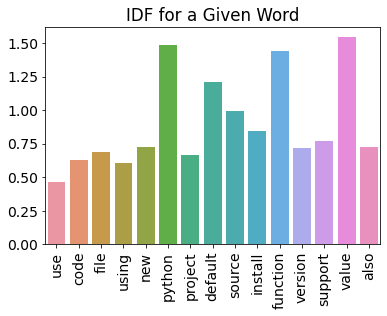

In [26]:
sns.barplot(x=idf_df.word, y=idf_df.idf)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation='vertical')
plt.title('IDF for a Given Word')
plt.show()

We created five groups in which to anaylize the words from the readme files. The first group is comprised of all the words from all readme files, regardless of programming language. JavaScript, Java, PHP, and Python make up the other four groups.

1. Distribution of the twenty most common words by programming language

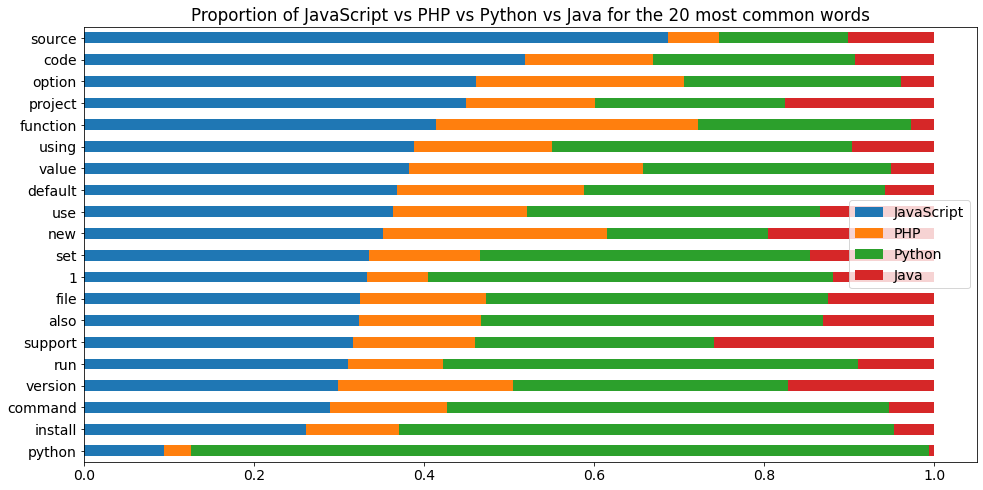

In [27]:
# word_counts is a dataframe of all words from the readme files quantifie per language
word_counts = explore.get_word_count(df)
explore.viz_most_common(word_counts)

- it looks like JavaScript and Python make up the larger proportion of the top twenty words

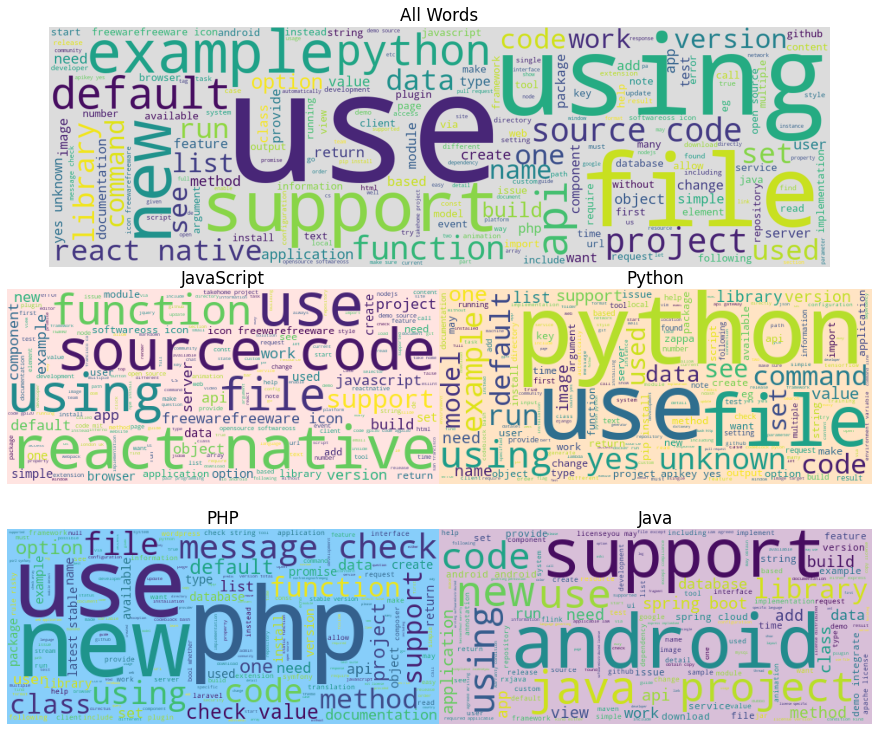

In [28]:
# creates a visual of word cloud subplot for the twenty most common words
# All Words represents the twenty most common words of all the readme's
# JavaScript, Python, PHP, and Java are the twenty most common words to the title language
explore.get_single_word_cloud(df)

**Takeaways:**

Of the four languages, JavaScript readme files are the least likely to repeat their name throught

There are some words that are used in all four languages.


### Bigrams

What do the twenty most bigrams look like?

Can grouping words help to better predict a programming language? 

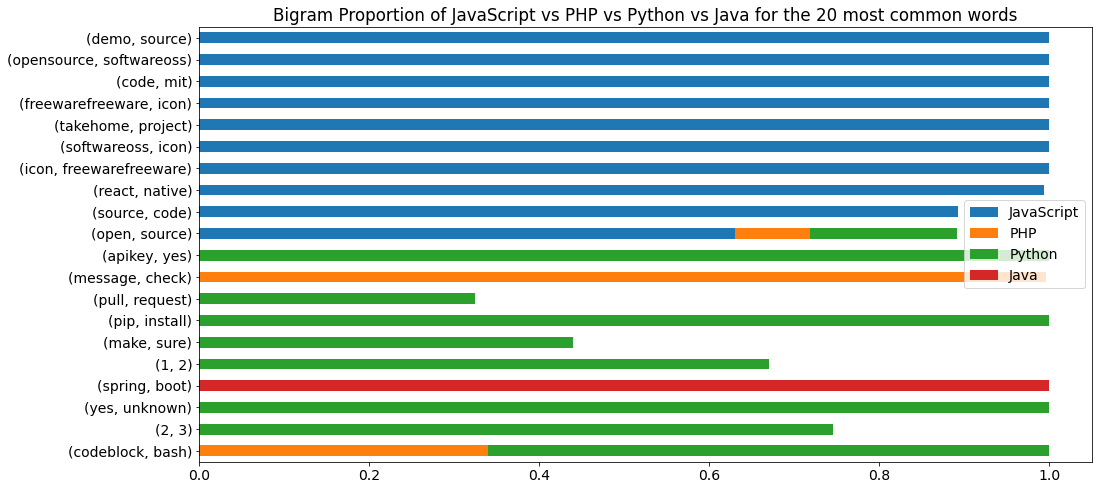

In [29]:
# bigram per language  
bigram_word_counts = explore.top_twenty_bigrams(df)
explore.viz_top_bigram(bigram_word_counts)

It looks like JavaScript makes up the most common words.

Python is the second most common.

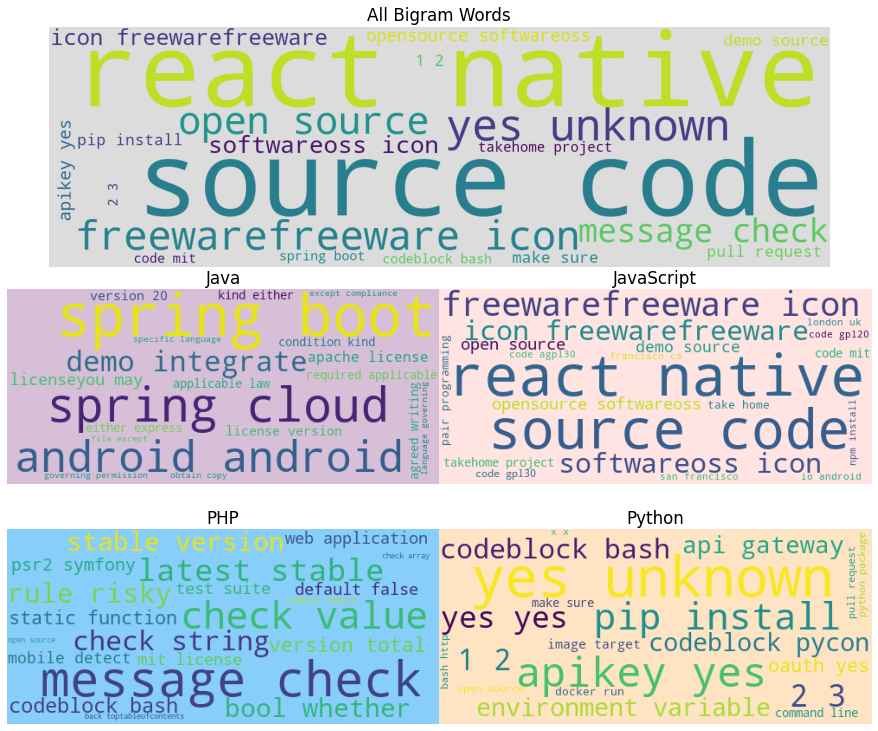

In [30]:
explore.get_bigram_word_cloud(df)

- here we see that bigrams are very language specific

### Modeling

#### Bag of Words Model

First we started with a model that uses how often each unique word from all documents appears in each document, also know as a bag of words. We will use the CountVectorizer to create a sparse matrix containing this information. We then split the data and feed the training set into a Decision Tree Classifier with a max depth of 10, which was determined through tuning on the validation set.

In [31]:
cv = CountVectorizer()
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=10, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 83.12%


We can see that the model has an accuracy for 83% but let's take a deeper look at the model's performance.

In [32]:
preds = tree.predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

        Java       0.92      0.76      0.83        45
  JavaScript       0.75      0.89      0.81        44
         PHP       0.86      0.86      0.86        35
      Python       0.83      0.83      0.83        36

    accuracy                           0.83       160
   macro avg       0.84      0.83      0.83       160
weighted avg       0.84      0.83      0.83       160



The main thing we will pay attention to here is the F1 score since it is the weighted mean of the precision and recall. As we can see the F1 score for each of the catagories is very similiar but we can see that the model is slightly better at predicting PHP.

Next let's look at the most important words to the model based on feature importance.

In [33]:
pd.Series(dict(zip(cv.get_feature_names(), tree.feature_importances_))).sort_values(ascending=False)[:6]

python        0.201688
php           0.154775
npm           0.143184
android       0.069025
java          0.061912
javascript    0.032466
dtype: float64

Above we are looking we are looking at the 6 most important words for the model. Notice that the name of each programming language that we are trying to predict appears on this list.

#### TF-IDF Model

Next we will make a model that uses how often the word appears in the document along with how many documents that word appears in, also know as TF-IDF (Term Frequency - Inverse Document Frequency). We will use the TfidfVectorizer to create a sparse matrix containing this information. We then split the data and feed the training set into a Decision Tree Classifier with a max depth of 7, which was determined through tuning on the validation set.

In [34]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=7, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 80.62%


We can see that the model has an accuracy for 80% but let's take a deeper look at the model's performance.

In [35]:
preds = tree.predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

        Java       0.94      0.69      0.79        45
  JavaScript       0.88      0.80      0.83        44
         PHP       0.91      0.83      0.87        35
      Python       0.62      0.94      0.75        36

    accuracy                           0.81       160
   macro avg       0.83      0.81      0.81       160
weighted avg       0.84      0.81      0.81       160



Again, let's mainly pay attention to the F1 score here. As we can see the F1 score for each of the catagories is less similiar than before but we can see that this model is still better at predicting PHP but is becoming worse at predicting Python.

Next let's look at the most important words to the model based on feature importance.

In [36]:
pd.Series(dict(zip(tfidf.get_feature_names(), tree.feature_importances_))).sort_values(ascending=False)[:6]

python        0.260552
php           0.189406
npm           0.152121
android       0.087964
java          0.085212
javascript    0.044568
dtype: float64

Above we are again looking we are looking at the 6 most important words for the model. Notice that the name of each programming language that we are trying to predict also appears on this list.

### Bag of Bigrams Model

Next we will make a model that uses how often a set of 2 words, also known as a bigram, appears in each document. We will use the CountVectorizer again to create a sparse matrix containing this information. We then split the data and feed the training set into a Decision Tree Classifier with a max depth of 16, which was determined through tuning on the validation set.

In [37]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=16, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 58.13%


We can see that the model has an accuracy for 58% but let's take a deeper look at the model's performance.

In [38]:
preds = tree.predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

        Java       1.00      0.53      0.70        45
  JavaScript       0.70      0.43      0.54        44
         PHP       0.35      0.91      0.51        35
      Python       1.00      0.50      0.67        36

    accuracy                           0.58       160
   macro avg       0.76      0.59      0.60       160
weighted avg       0.78      0.58      0.60       160



Again, let's mainly pay attention to the F1 score here. As we can see the F1 score for each of the categories is very different and it does pretty poor on all of them.

Next let's look at the most important words to the model based on feature importance.

In [39]:
pd.Series(dict(zip(cv.get_feature_names(), tree.feature_importances_))).sort_values(ascending=False)[:10]

pip install                      0.218810
npm install                      0.112191
apache license                   0.103715
composer require                 0.049652
project test                     0.040399
written python                   0.035551
spring boot                      0.034574
public void                      0.032845
google cloud                     0.032004
contributingthank considering    0.030175
dtype: float64

Above we are looking we are looking at the 10 most important words for the model. Notice that we still see the word python in there but we also see some common commands like pip install and npm install.

### Bag of Trigrams Model

Lastly we will make a model that uses how often a set of 3 words, also known as a trigram, appears in each document. We will use the CountVectorizer again to create a sparse matrix containing this information. We then split the data and feed the training set into a Decision Tree Classifier with a max depth of 15, which was determined through tuning on the validation set.

In [40]:
cv = CountVectorizer(ngram_range=(3, 3))
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=15, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 43.75%


We can see that the model has an accuracy for 44% but let's take a deeper look at the model's performance.

In [41]:
preds = tree.predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

        Java       1.00      0.24      0.39        45
  JavaScript       0.33      0.98      0.49        44
         PHP       1.00      0.20      0.33        35
      Python       0.90      0.25      0.39        36

    accuracy                           0.44       160
   macro avg       0.81      0.42      0.40       160
weighted avg       0.79      0.44      0.41       160



Again, let's mainly pay attention to the F1 score here. As we can see the F1 score for each of the categories is very different and it does the worst so far on all of them.

Next let's look at the most important words to the model based on feature importance.

# Best Model

So our best model was the model using the bag of words. It had both the best accuracy and the best F1 score for each category. Now let's see how it does on the test data

In [42]:
cv = CountVectorizer()
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=10, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 83.12%


In [43]:
preds = tree.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        Java       0.79      0.71      0.75        38
  JavaScript       0.58      0.80      0.67        40
         PHP       0.91      0.81      0.85        36
      Python       0.82      0.70      0.75        46

    accuracy                           0.75       160
   macro avg       0.78      0.75      0.76       160
weighted avg       0.77      0.75      0.75       160



### Below is the code used to generate the Decision Tree Visual found in the repository; `github-prediction-tree.pdf`.

In [44]:
# dot_data = export_graphviz(tree, 
#                            feature_names= cv.get_feature_names(),
#                            class_names= ['Java', 'JavaScript', 'PHP', 'Python'],
#                            out_file=None) 
# graph = graphviz.Source(dot_data) 

# graph.render('github-prediction-tree', view=True)

### Now let's make a function that predicts on new readme using all of our data

In [45]:
import model

In [46]:
tester = '''# snakeware
snakeware is a free Linux distro with a Python userspace inspired by the Commodore 64. You are booted directly into a
Python interpreter, which you can use to do whatever you want with your computer.

Our designated IRC channel is `#snakeware` on `irc.rizon.net`.

[Check out our latest demo on YouTube!](https://www.youtube.com/watch?v=spJD7uZAkds)

![snakeware/snakewm running in QEMU](screenshot.png)

## Motivation
The idea is that a Python OS would be fun to use and very easy to contribute to. Even relative beginners might be able
to find ways to meaningfully contribute apps and other code to this distro.

Our window manager, snakewm, is based on pygame/pygame_gui. We do not use X11; snakewm draws directly to `/dev/fb0`.

We also are not going to be using any other huge and opaque software such as systemd, etc. The goal is to eventually
have a usable set of userspace apps and utilities written entirely in Python, because Python is fun and it Just Werks™.

## Running
[Download the latest release image.](https://github.com/joshiemoore/snakeware/releases)

You can burn the image file to a flash drive and boot it. Instructions to run it on QEMU are below.


### QEMU

To run it snakeware on QEMU:

1. [Download and Install QEMU](https://www.qemu.org/download/). Supports Linux, OSX, and Windows.
2. Open your terminal/command prompt.
3. Navigate to the directory/folder where the snakeware image image was downloaded.
4. Run the command: `qemu-system-x86_64 -drive format=raw,file=snakeware.img -m 2048 -soundhw hda -audiodev id=pa,driver=pa`
5. Wait for it to load.
6. You will be be taken to a Python environment/shell.
7. Launch snakewm with the following Python command:

```
>>> from snakewm.wm import SnakeWM
>>> SnakeWM().run()
```
8. To open the app menu press the left WinKey (Left CMD key ⌘ on macOS).


## Building
The snakeware build system is based on buildroot. See the `snakeware/` directory in this repo for resources and
documentation on how to build your own snakeware distro image.

**NOTE:** If you are only contributing apps or other code to snakewm, you don't need to build a whole snakeware distro 
image to test your changes. Simply make your changes to snakewm then run `sudo python wm.py` in the `snakewm/` 
directory. snakewm will then start drawing itself directly to the framebuffer and you can test out your changes. 
Press `ALT+ESC` to return to your normal desktop. (It would still be good to test your changes in an actual
snakeware environment though.)

## Contributing
Developers of all experience levels are welcome and encouraged to contribute to snakeware. Python enthusiasts that are
familiar with pygame and pygame_gui will be able to write their own snakeware apps very easily. See existing apps
in `snakewm/apps/` for examples of how to get started, and feel free to ask questions if you need help.

Those with experience building Linux systems are encouraged to contribute to the underlying aspects of the distro,
such as the build/package scripts and configuration for the kernel, GRUB, etc. The build system is currently not
very streamlined or robust, and I am sure that there are better ways to do a lot of it.

I would also like to eventually stop using Busybox for intialization and find a way to perform all necessary init from
the Python environment, so ideas about that are welcome.

## TODO
This is an abridged list of future plans:

* Raspberry Pi configs for buildroot and kernel!!!!!!!
* Fix pip module installation - won't work when cross-compiling
* Many more snakewm apps
* ~~App menu for choosing apps to run~~
* ~~Improved/streamlined build system~~
* Improved kernel config
* snake-games - full-screen user games separate from SnakeWM
* ~~Modify partition scheme for faster boot - /usr on its own partition?~~
* Take advantage of pygame_gui's theme functionality
* ~~Dynamic/interactive desktop backgrounds~~
* ~~Sound support~~
* Networking -> web browser
    + snakechat - chat with everyone else who's using snakeware
    + Gopher client?
* Ditch busybox, init via Python somehow
* ...
'''

In [47]:
model.predict_readme_language(tester)

array(['Python'], dtype=object)

#### And a nice little cherry on top because it is right on this one.